<a target="_blank" href="https://colab.research.google.com/github/Bop2000/DANTE/blob/main/notebooks/DANTE_VL_Lunar_Landing.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


################################################################################
> # **Clone GitHub repository**
################################################################################


In [1]:
################# Clone repository from github to colab session ################

"""

run this section if you want to clone all the datasets, preTrained networks from the GitHub
repository to this colab session

"""


print("Start============================================================================================")

!git clone https://github.com/Bop2000/DANTE

print("Done============================================================================================")



Start============================================================================================
fatal: destination path 'DANTE' already exists and is not an empty directory.
Done============================================================================================


In [2]:
"""

run this section if you want to copy all files and folders from cloned folder
(DANTE/SelfDriving_Virtual_Labs/Lunar_Landing) to current directory (/content/ or ./)

So you can load all the FE simulation dataset, preTrained networks files without changing any paths

"""

print("============================================================================================")

!cp -rv ./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/* ./

print("============================================================================================")


'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/dante.py' -> './dante.py'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/obj_functions.py' -> './obj_functions.py'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/README.md' -> './README.md'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/run.py' -> './run.py'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/run.sh' -> './run.sh'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/Source_Data/CMA-ES-LunarLander100/result' -> './Source_Data/CMA-ES-LunarLander100/result'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/Source_Data/DANTE-LunarLander100/result' -> './Source_Data/DANTE-LunarLander100/result'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/Source_Data/DOO-LunarLander100/result' -> './Source_Data/DOO-LunarLander100/result'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landing/Source_Data/DifferentialEvolution-LunarLander100/result' -> './Source_Data/DifferentialEvolution-LunarLander100/result'
'./DANTE/SelfDriving_Virtual_Labs/Lunar_Landin

In [3]:

"""

run this section if you want to delete original cloned folder and the cloned ipynb file
(after you have copied its contents to current directory)

"""


print("============================================================================================")

# delete original cloned folder
!rm -r ./DANTE

# delete cloned ipynb file
!rm ./DANTE_VL_Lunar_Landing.ipynb

print("============================================================================================")



rm: remove write-protected regular file './DANTE/.git/objects/pack/pack-4ec4986ee6ae35abea5c73fceed27c15bf8c72e5.idx'? ^C


################################################################################
> # **Install Dependencies**
################################################################################

In [4]:

############ install compatible version of gymnasium and ###########

# !pip install gymnasium

# !pip install scipy

# !pip install numpy

# !pip install pandas

# !pip install matplotlib

# !pip install scikit-learn

# !pip install scikit-image

# !pip install tqdm

# !pip install seaborn

# !pip install openpyxl


################################################################################
> # **Introduction**
> The notebook is divided into 4 major parts :

*   **Part I** : define the functions
*   **Part II** : define the search algorithm
*   **Part III** : optimization using the search algorithm

################################################################################

################################################################################
> # **Part - I**

*   Define the functions

################################################################################

In [5]:

############################### Import libraries ###############################

import argparse
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import random
import matplotlib.pyplot as plt

import json
import gymnasium as gym

In [6]:

############################### Set the objective ###############################

class args:
    def __init__(self, func = None, dims = 10, iters = 1000, method = None):
        self.dims    = dims 
        self.func    = func
        self.iterations =  iters
        self.method  = method

args = args(func ='LunarLander',            # specify the test function
            dims = 100,                 # specify the problem dimensions
            iters = 10000,              # specify the iterations to collect in the search
            method = 'DANTE'           # specify the method to search
            )


# Set the random seed for reproducibility
random.seed(42)


In [7]:
############################### Define the functions ###############################

class LunarLander:
    
    def __init__(self, dims=100, turn=1):
        self.dims         = dims
        self.lb           = 0 * np.ones(self.dims)
        self.ub           = 3 * np.ones(self.dims)
        self.counter      = 0
        self.env          = gym.make("LunarLander-v3")
        
        self.turn    = turn
        
   
    def __call__(self, x):
        x = np.array(x / self.turn).round(0) * self.turn
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        obs, info    = self.env.reset(seed=42)
        # print(obs)
        done1   = False
        done2   = False
        totalr = 0.
        steps  = 0
        
        for i in range(self.dims):
            action = round(x[i])
            # print(action,'action')
            obs, r, done1, done2, _ = self.env.step(action)
            totalr += r
            steps  += 1
            if done1 or done2:
                break

        return totalr




class tracker:
    def __init__(self, foldername):
        self.counter   = 0
        self.results   = []
        self.curt_best = float("-inf")
        self.curt_best_x = None
        self.foldername = foldername
        try:
            os.mkdir(foldername)
        except OSError:
            print ("Creation of the directory %s failed" % foldername)
        else:
            print ("Successfully created the directory %s " % foldername)
        
    def dump_trace(self):
        # trace_path = self.foldername + '/result' + str(len( self.results) )
        trace_path = self.foldername + '/result'
        final_results_str = json.dumps(self.results)
        with open(trace_path, "a") as f:
            f.write(final_results_str + '\n')
            
    def track(self, result, x = None, iters = 1000):
        if result > self.curt_best:
            self.curt_best = result
            self.curt_best_x = x
            print("")
            print("="*10)
            print("iteration:", self.counter, "total samples:", len(self.results) )
            print("="*10)
            print("current best f(x):", self.curt_best)
            print("current best x:", np.around(self.curt_best_x, decimals=0))
        self.results.append(self.curt_best)
        self.counter += 1
        if len(self.results) == iters:
            self.dump_trace()
        elif round(self.curt_best,5) == 0:
            self.dump_trace()



class Surrogate:
    def __init__(self, dims=3, name = 'method', f=None, iters = None):
        self.dims  = dims
        self.name  = name
        self.f     = f
        self.counter = 0
        self.tracker = tracker(name+str(dims))
        self.iters = iters
        self.turn = f.turn
        self.lb   = f.lb
        self.ub   = f.ub

    def __call__(self, x):
        x = np.array(x)
        self.counter += 1
        assert len(x) == self.dims
        assert x.ndim == 1
        result = self.f(x.reshape(self.dims))
        
        self.tracker.track( result, x, self.iters)
                
        return result 



iteration = 0
f = LunarLander(dims =args.dims)
fx = Surrogate(dims =args.dims, name=args.method+'-LunarLander', f=f, iters = args.iterations)



assert args.dims > 0
assert f is not None
assert args.iterations > 0

lower = f.lb
upper = f.ub

bounds = []
for idx in range(0, len(f.lb) ):
    bounds.append( ( float(f.lb[idx]), float(f.ub[idx])) )

Successfully created the directory DANTE-LunarLander100 


In [8]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   Define the DANTE alghorithm

################################################################################

In [9]:
################################# DANTE alghorithm ################################

def create_new(tup, index, aaa, f):
    flip = random.randint(0,5)
    if flip ==0:
        for i in range(int(f.dims/5)):
          index_2 = random.randint(0, len(tup)-1)
          tup[index_2] = np.random.choice(aaa)
    elif flip ==1:
        for i in range(int(f.dims/10)):
          index_2 = random.randint(0, len(tup)-1)
          tup[index_2] = np.random.choice(aaa)
    elif flip ==2:
        for i in range(int(f.dims/20)):
          index_2 = random.randint(0, len(tup)-1)
          tup[index_2] = np.random.choice(aaa)
    elif flip ==3:
        for i in range(int(f.dims/50)):
          index_2 = random.randint(0, len(tup)-1)
          tup[index_2] = np.random.choice(aaa)
    elif flip ==4:
        for i in range(int(f.dims/3)):
          index_2 = random.randint(0, len(tup)-1)
          tup[index_2] = np.random.choice(aaa)
    else:
        tup[index] = np.random.choice(aaa)
    tup[index] = round(tup[index],5)
    if tup[index] > f.ub[0]:
        tup[index] = f.ub[0]
    if tup[index] < f.lb[0]:
        tup[index] = f.lb[0]
    return tup

################################# DANTE alghorithm ################################

#######################################################
class DANTE:
    def __init__(self, exploration_weight=None, f = None, name = None):
        self.Q = defaultdict(int)  # total reward of each node
        self.Qa = dict.fromkeys(list(range(20)), 0)
        self.Na = dict.fromkeys(list(range(20)), 1)
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight
        
        print(self.exploration_weight)
        self.f = f
        self.name = name

    def choose(self, node):
        "Choose the best successor of node."
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            print('not seen before, randomly sampled!')
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
               return '-inf'  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward
        def evaluate(n):
            return n.value  # average reward
        log_N_vertex = math.log(self.N[node])
        def uct(n):
            "Upper confidence bound for trees"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value

        media_node = max(self.children[node], key=uct)

        if uct(media_node) > uct(node):
            return media_node
        return node

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        count = 0
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
              return path
            unexplored = self.children[node] - self.children.keys()
            def evaluate(n):
              return n.value
            if count == 5:
                return path
          
            if unexplored:
              path.append(max(unexplored, key=evaluate))#
              return path
            node = self._uct_select(node)  # descend a layer deeper
            count+=1

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        # if node in self.children:
        #     return  # already expanded
        action = [p for p in range(0, len(node.tup))]
        # action = [p for p in range(0, int(len(node.tup)/2))]
        self.children[node] = node.find_children(action, self.f)

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        # reward = node.reward()
        reward = node.reward(self.f)
        return reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
          self.N[node] += 1
          self.Q[node] += reward

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value
        uct_node = max(self.children[node], key=uct)
        return uct_node

class Node(ABC):
    """
    A representation of a single board state.
    DOTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """
    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True


_OT = namedtuple("opt_task", "tup value terminal")

# Inheriting from a namedtuple is convenient because it makes the class
# immutable and predefines __init__, __repr__, __hash__, __eq__, and others
class opt_task(_OT, Node):
        
    def find_children(board,action,f):
        if board.terminal:  # If the game is finished then no moves can be made
            return set()
        return {
            board.make_move(i, f) for i in action}

    def find_random_child(board):
        pass

    def find_uct_child(board, action):
        pass

    def reward(board,f):
        return board.value

    def is_terminal(board):
        return board.terminal

    def make_move(board, index, f):
        tup = list(board.tup)
        aaa = np.arange(f.lb[0], f.ub[0] + f.turn, f.turn).round(5)
        
        tup = create_new(tup, index, aaa, f)
            
        value = round(f(np.array(tup)),10)
        is_terminal = False
        return opt_task(tuple(tup), value, is_terminal)




In [10]:




################################ End of Part II ################################






################################################################################
> # **Part - III**

*   Optimization using DANTE

################################################################################

In [11]:
################################ Optimization using DANTE ###############################

aaa = np.arange(f.lb[0], f.ub[0] + f.turn, f.turn)
init_X = np.random.choice(aaa,size=(args.dims))
init_y = round(fx(init_X),10)

ratio = 0.5

exp_weight = ratio * init_y

board_ubt = opt_task(tup=tuple(init_X), value=init_y, terminal=False)
tree_ubt = DANTE(exploration_weight=exp_weight, f=fx, name=args.func)
for i in range(args.iterations // args.dims):
    tree_ubt.do_rollout(board_ubt)
    board_ubt = tree_ubt.choose(board_ubt)
    fy = f(np.array(board_ubt.tup))
    tree_ubt.exploration_weight = ratio * round(fy,10)



iteration: 0 total samples: 0
current best f(x): -64.04226128209184
current best x: [0. 0. 0. 2. 1. 2. 1. 2. 0. 3. 2. 3. 3. 1. 0. 3. 0. 1. 3. 2. 1. 3. 2. 2.
 2. 1. 3. 0. 2. 3. 3. 1. 2. 3. 3. 2. 3. 0. 3. 0. 1. 1. 2. 2. 0. 0. 1. 0.
 1. 1. 2. 3. 3. 0. 3. 0. 0. 3. 0. 1. 1. 1. 2. 1. 0. 2. 3. 0. 1. 1. 3. 2.
 2. 3. 3. 0. 0. 0. 2. 0. 3. 1. 0. 0. 0. 2. 0. 1. 3. 2. 1. 1. 0. 3. 2. 1.
 1. 3. 1. 3.]
-32.02113064105

iteration: 3 total samples: 3
current best f(x): -37.826737749408906
current best x: [1. 0. 0. 1. 1. 2. 1. 2. 0. 3. 2. 0. 3. 0. 0. 3. 0. 1. 3. 0. 3. 3. 2. 2.
 2. 0. 3. 0. 2. 3. 3. 1. 2. 0. 3. 2. 3. 0. 3. 0. 1. 1. 2. 2. 1. 1. 1. 0.
 3. 1. 2. 3. 3. 3. 0. 0. 0. 0. 0. 1. 1. 1. 2. 1. 0. 2. 3. 0. 1. 0. 3. 1.
 2. 3. 3. 0. 0. 1. 2. 0. 3. 1. 0. 0. 0. 2. 0. 1. 3. 0. 1. 0. 0. 2. 2. 1.
 1. 2. 1. 3.]

iteration: 4 total samples: 4
current best f(x): -27.123081541503918
current best x: [0. 0. 0. 2. 1. 2. 1. 2. 0. 3. 2. 3. 3. 1. 0. 1. 0. 1. 3. 2. 1. 3. 2. 2.
 2. 1. 3. 0. 2. 3. 3. 1. 2. 3. 3. 2. 3. 0.

DANTE-LunarLander100 1


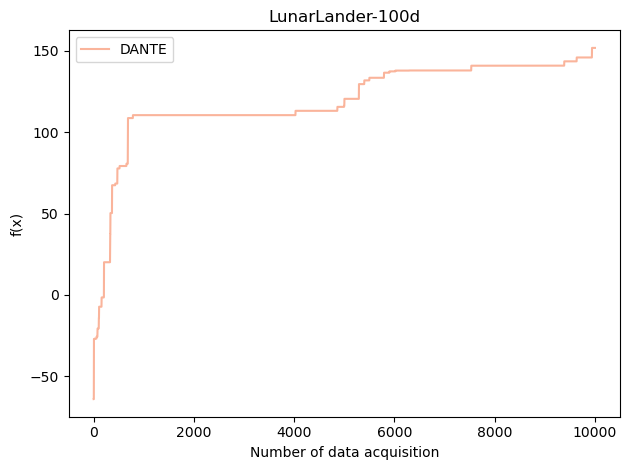

In [14]:
################################ Visualization ###############################


def process(name):
    f = open('./'+name+'/result')
    yourList = f.readlines()
    yourList2=[]
    max_len = 0
    for i in yourList:
        i=i.strip('[')
        i=i.strip(']\n')
        i = [item.strip() for item in i.split(',')]
        yourList2.append(i)
        if len(i) > max_len:
            max_len = len(i)
    yourList3 = []
    samples = []
    for i in yourList2:
        ii = np.array(i).astype(float)
        samples.append(len(ii))
        if len(ii) < max_len:
            ii = np.concatenate((ii, np.zeros(max_len-len(ii))))
        yourList3.append(ii)
    yourList3 = np.array(yourList3)
    mean = np.mean(yourList3, axis=0)
    std = np.std(yourList3, axis=0)
    print(name,len(yourList2))
    return mean, std

labels = ['DANTE']
labels1 = ['DANTE']
colors  = ['#FAB49B', ]

funcs = args.func
dims = args.dims
plt.figure()
for l,i in enumerate(labels):
    try:
        mean, std = process(i + '-' + funcs + str(dims))
        plt.plot(np.arange(len(mean)), mean, '-', label = labels1[l], color = colors[l])
        plt.fill_between(np.arange(len(mean)), mean -std, mean + std, alpha=0.2, facecolor=colors[l])
    except:
        pass

plt.xlabel('Number of data acquisition')
plt.ylabel('f(x)')
plt.title(funcs +'-'+str(dims)+'d')

plt.legend(prop={'size':10})
#plt.ylim(-300,180)
plt.tight_layout()


In [13]:



################################ End of Part III ################################




################################################################################

---------------------------------------------------------------------------- That's all folks ! ----------------------------------------------------------------------------


################################################################################